# Анализ данных для финансовой компании

## Импорты

In [1]:
import pandas as pd
import numpy as np
import janitor
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

## Загрузка и подготовка данных для анализа

### Таблица с покупками

In [64]:
# Загружаем файл с покупками
df_purchases = pd.read_csv('data/purchases', sep='\t')

In [65]:
df_purchases

,buy_ts,uid,revenue
0,23.07.2016 19:13:54,3492372810,"1,47"
1,06.11.2016 02:48:27,1564753091,"1,11"
2,31.01.2017 20:32:42,1385616391,"16,8"
3,11.01.2017 10:52:11,2636761148,11
4,25.11.2016 18:57:09,2945629974,"4,89"
...,...,...,...
75711,06.05.2017 20:24:38,2951816379,"3,91"
75712,13.12.2016 15:43:19,2284837671,"7,06"
75713,15.01.2017 20:35:46,3719473001,"3,54"
75714,04.12.2016 00:12:30,4197687030,11


In [66]:
# Проверим типы данных в файле
df_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75716 entries, 0 to 75715
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   buy_ts   75716 non-null  object
 1   uid      75716 non-null  int64 
 2   revenue  75716 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [67]:
# Преобразуем тип данных столбца с выручкой
df_purchases['revenue'] = df_purchases['revenue'].str.replace(',', '.').astype(float)

# Преобразуем дату в правильный тип данных
df_purchases['buy_ts'] = pd.to_datetime(df_purchases['buy_ts'], dayfirst=True)

# Проверим процент пропущенных значений
((df_purchases.isna().sum() / len(df_purchases)) * 100).sort_values(ascending=False)

buy_ts     0.0
uid        0.0
revenue    0.0
dtype: float64

In [68]:
# Проверим дубликаты
df_purchases.duplicated().sum()

0

In [69]:
# Создадим новый признак с датой покупки для последующего анализа
df_purchases['buy_dt'] = df_purchases['buy_ts'].dt.date
df_purchases['buy_dt'] = pd.to_datetime(df_purchases['buy_dt'])

### Таблица с визитами

In [70]:
# Загружаем файл с посещениями
df_visits = pd.read_csv('data/visits', sep='\t')

In [71]:
df_visits

,device,end_ts,source_id,start_dt,start_ts,uid
0,desktop,2016-11-30T11:04:17Z,2,2016-11-30,2016-11-30T10:53:49Z,3758486201
1,desktop,2016-11-10T23:16:57Z,4,2016-11-10,2016-11-10T23:08:04Z,2933941628
2,desktop,2016-10-19T18:51:56Z,1,2016-10-19,2016-10-19T18:48:16Z,1465872791
3,desktop,2017-01-12T20:51:55Z,9,2017-01-12,2017-01-12T20:50:10Z,2751875787
4,touch,2016-07-23T19:17:19Z,4,2016-07-23,2016-07-23T19:10:57Z,3492372810
...,...,...,...,...,...,...
720674,desktop,2016-11-25T23:31:38Z,3,2016-11-25,2016-11-25T23:23:22Z,1716334840
720675,touch,2017-05-18T22:25:52Z,5,2017-05-18,2017-05-18T22:23:41Z,938860205
720676,desktop,2016-07-10T16:34:52Z,5,2016-07-10,2016-07-10T16:04:00Z,1101396587
720677,touch,2017-02-10T22:54:13Z,4,2017-02-10,2017-02-10T22:33:32Z,3918143187


In [72]:
# Проверим типы данных в таблице
df_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720679 entries, 0 to 720678
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   device     720679 non-null  object
 1   end_ts     720679 non-null  object
 2   source_id  720679 non-null  int64 
 3   start_dt   720679 non-null  object
 4   start_ts   720679 non-null  object
 5   uid        720679 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 33.0+ MB


In [73]:
# Преобразуем признаки с датой и временем
df_visits['end_ts'] = pd.to_datetime(df_visits['end_ts']).dt.tz_localize(None)
df_visits['start_dt'] = pd.to_datetime(df_visits['start_dt'])
df_visits['start_ts'] = pd.to_datetime(df_visits['start_ts']).dt.tz_localize(None)

In [74]:
# Как и в таблице с покупками проверим дубликаты
df_visits.duplicated().sum()

0

In [75]:
# И пропущенные значения
((df_visits.isna().sum() / len(df_visits)) * 100).sort_values(ascending=False)

device       0.0
end_ts       0.0
source_id    0.0
start_dt     0.0
start_ts     0.0
uid          0.0
dtype: float64

### Объединение таблиц

In [76]:
# Сортируем данные по времени для корректного слияния
df_purchases.sort_values(by=['buy_ts'], inplace=True)
df_visits.sort_values(by=['start_ts'], inplace=True)

# Выполняем объединение
merged_df = df_visits.conditional_join(
    df_purchases,
    ('uid', 'uid', '=='),
    ('start_ts', 'buy_ts', '<='),
    ('end_ts', 'buy_ts', '>='),
    right_columns=['buy_ts', 'revenue','buy_dt'],
    how='left')

In [77]:
merged_df

,device,end_ts,source_id,start_dt,start_ts,uid,buy_ts,revenue,buy_dt
0,desktop,2016-06-01 00:13:13,1,2016-06-01,2016-06-01 00:09:59,4259681203,2016-06-01 00:12:24,17.00,2016-06-01
1,desktop,2016-06-01 00:23:17,5,2016-06-01,2016-06-01 00:13:35,2518268180,2016-06-01 00:19:55,11.73,2016-06-01
2,desktop,2016-06-01 00:26:52,2,2016-06-01,2016-06-01 00:14:04,3701945751,2016-06-01 00:19:03,0.55,2016-06-01
3,desktop,2016-06-01 00:34:47,2,2016-06-01,2016-06-01 00:14:12,779283844,2016-06-01 00:18:59,0.55,2016-06-01
4,desktop,2016-06-01 00:39:46,5,2016-06-01,2016-06-01 00:16:05,369652828,2016-06-01 00:27:58,5.38,2016-06-01
...,...,...,...,...,...,...,...,...,...
721368,desktop,2017-06-01 00:27:26,1,2017-05-31,2017-05-31 23:59:07,3717401413,NaT,NaN,NaT
721369,touch,2017-06-01 00:13:59,10,2017-05-31,2017-05-31 23:59:27,4142775048,NaT,NaN,NaT
721370,desktop,2017-06-01 00:13:16,3,2017-05-31,2017-05-31 23:59:28,1704136536,NaT,NaN,NaT
721371,touch,2017-06-01 00:08:22,2,2017-05-31,2017-05-31 23:59:28,890177695,NaT,NaN,NaT


## Предварительный анализ данных

### Анализ распределения выручки

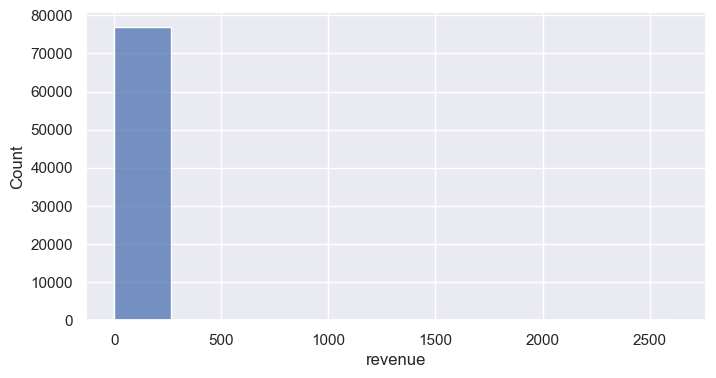

In [78]:
 #Проверим распределение выручки
sns.set_theme()
plt.figure(figsize=(8, 4))
sns.histplot(merged_df['revenue'], palette='husl', bins=10)
plt.show()

In [79]:
# Проверим средний размер покупки и медианный размер покупки
print(f'Средний размер покупки: {round(merged_df['revenue'].mean(), 2)}')
print(f'Медианный размер покупки: {round(merged_df['revenue'].median(), 2)}')

Средний размер покупки: 4.95
Медианный размер покупки: 2.57


Из-за большого количества аномальных значений средний размер покупки и медианный различаются почти в 2 раза.

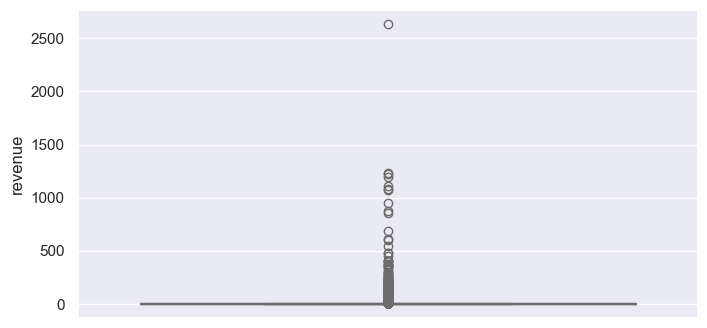

In [80]:
# И построим boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(merged_df['revenue'], palette='husl')
plt.show()

Из этих графиков видно, что большинство покупок совершается на сумму до 250 долларов, но есть операции в которых было потрачено около 2500 долларов.

In [81]:
# Посмотрим на эти операции
merged_df[merged_df['revenue'] > 250].head(20)

,device,end_ts,source_id,start_dt,start_ts,uid,buy_ts,revenue,buy_dt
2402,desktop,2016-06-14 14:17:28,2,2016-06-14,2016-06-14 13:11:08,248091473,2016-06-14 14:03:30,484.00,2016-06-14
14919,desktop,2016-09-26 23:31:01,3,2016-09-26,2016-09-26 22:35:26,851895265,2016-09-26 23:25:23,550.00,2016-09-26
17801,desktop,2016-10-06 12:09:13,1,2016-10-06,2016-10-06 11:05:39,3728286989,2016-10-06 11:50:46,276.22,2016-10-06
17960,desktop,2016-10-06 16:23:55,2,2016-10-06,2016-10-06 14:43:37,3069111765,2016-10-06 15:09:19,480.55,2016-10-06
27219,desktop,2016-11-11 18:43:01,5,2016-11-11,2016-11-11 18:26:14,4121691286,2016-11-11 18:28:55,407.00,2016-11-11
28070,desktop,2016-11-15 12:30:14,1,2016-11-15,2016-11-15 12:05:59,2517874452,2016-11-15 12:20:53,250.55,2016-11-15
29782,desktop,2016-11-21 22:18:55,1,2016-11-21,2016-11-21 21:52:30,3728286989,2016-11-21 22:11:19,366.67,2016-11-21
29910,touch,2016-11-22 18:41:36,2,2016-11-22,2016-11-22 14:16:59,3373857415,2016-11-22 15:11:29,367.28,2016-11-22
29911,touch,2016-11-22 18:41:36,2,2016-11-22,2016-11-22 14:17:40,3373857415,2016-11-22 15:11:29,367.28,2016-11-22
30483,desktop,2016-11-24 14:33:39,1,2016-11-24,2016-11-24 11:21:26,775006587,2016-11-24 11:50:53,263.63,2016-11-24


In [82]:
print('Всего операций с суммой больше 250 долларов:', len(merged_df[merged_df['revenue'] > 250]))
print('Количество уникальных клиентов совершающих эти операции:', 
      merged_df[merged_df['revenue'] > 250][['uid']].nunique()[0])
print('Процент таких операций от общего числа', 
      len(merged_df[merged_df['revenue'] > 250]) / len(merged_df[merged_df['revenue'] > 0]) * 100)

Всего операций с суммой больше 250 долларов: 39
Количество уникальных клиентов совершающих эти операции: 14
Процент таких операций от общего числа 0.05069082496068211


Небольшая доля клиентов совершает операции свыше 250 долларов. Т.к. для того, чтобы принять решение об удалении этих аномальных значений данных недостаточно, оставим эту информацию в выборке.

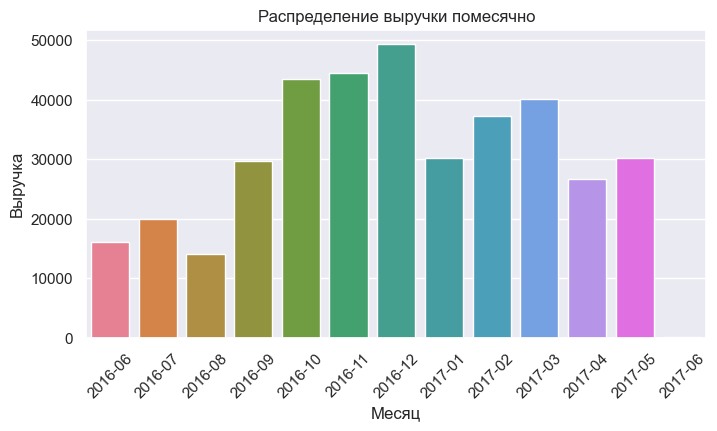

In [83]:
# Также построим график о распределении выручки помесячно

grouped_df = merged_df.groupby(pd.Grouper(key='buy_dt', freq='M'))['revenue'].sum().reset_index()

# Добавляем название месяца
grouped_df['month'] = grouped_df['buy_dt'].dt.strftime('%Y-%m')

# Строим график с помощью seaborn
plt.figure(figsize=(8, 4))
ax = sns.barplot(x="month", y="revenue", data=grouped_df, palette='husl')

# Настраиваем оси и заголовок
plt.xlabel('Месяц')
plt.ylabel('Выручка')
plt.title('Распределение выручки помесячно')
plt.xticks(rotation=45)
plt.show()

В данном случае каких-либо аномалий в данных нет, видна определенная сезонность, но данных также недостаточно, чтобы это утверждать.

Проверим распределение выручки по источникам трафика и устройствам

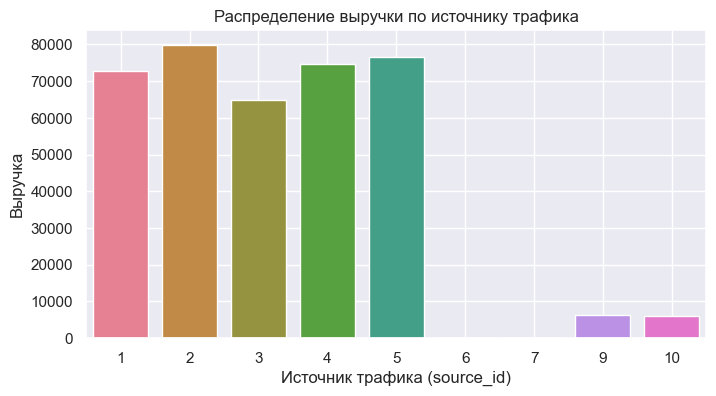

In [84]:
# Группируем данные по source_id и суммируем revenue
grouped_by_source = merged_df.groupby(['source_id'])['revenue'].sum().reset_index()

# Строим график для источника трафика
plt.figure(figsize=(8, 4))
sns.barplot(x='source_id', y='revenue', data=grouped_by_source, palette='husl')
plt.xlabel('Источник трафика (source_id)')
plt.ylabel('Выручка')
plt.title('Распределение выручки по источнику трафика')
plt.grid(True)
plt.show()


По этому графику видно, что есть 5 источников, которые приносят наибольшую выручку и два источника которые практически не генерирует выручку, если учитывать модель атрибуции по последнему клику.

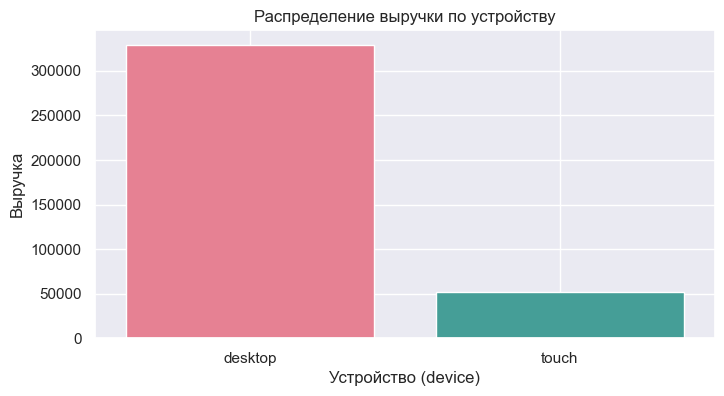

In [85]:
# Группируем данные по device и суммируем revenue
grouped_by_device = merged_df.groupby(['device'])['revenue'].sum().reset_index()

# Строим график для устройства
plt.figure(figsize=(8, 4))
sns.barplot(x='device', y='revenue', data=grouped_by_device, palette='husl')
plt.xlabel('Устройство (device)')
plt.ylabel('Выручка')
plt.title('Распределение выручки по устройству')
plt.grid(True)
plt.show()

Наибольшую выручку приносят десктопные устройства

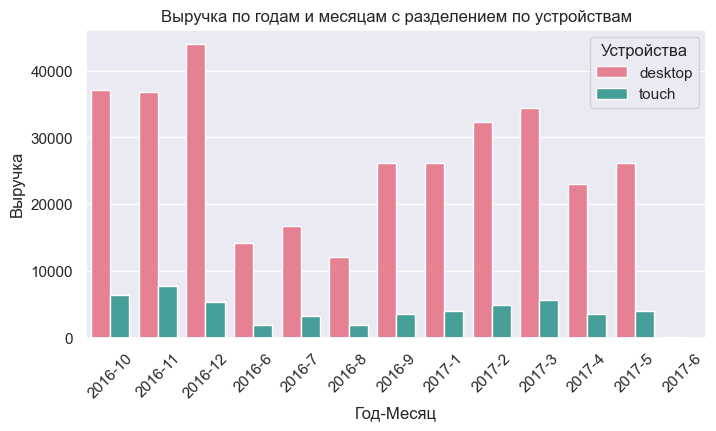

In [86]:
device_date = merged_df.copy()
device_date['buy_dt'] = pd.to_datetime(device_date['buy_dt'], errors='coerce') 

# Удаляем строки с NaN значениями
device_date.dropna(subset=['buy_dt'], inplace=True)

# Извлекаем год и месяц из даты
device_date['year_month'] = device_date['buy_dt'].apply(lambda x: f"{x.year}-{x.month}")

# Группируем данные по году и месяцу, а также по устройствам, суммируя revenue
grouped_device_date = device_date.groupby(['year_month', 'device'])['revenue'].sum().reset_index()

# Строим barplot с помощью seaborn
plt.figure(figsize=(8, 4))
sns.barplot(x='year_month', y='revenue', hue='device', data=grouped_device_date, palette='husl')

# Настраиваем оси и заголовок
plt.xlabel('Год-Месяц')
plt.ylabel('Выручка')
plt.title('Выручка по годам и месяцам с разделением по устройствам')
plt.legend(title='Устройства')
plt.xticks(rotation=45)
plt.show()

Если рассматривать выручку по устройствам и месяцам каких либо аномалий также не наблюдается

### Анализ выручки по клиентам

Объединим данные по клиентам и посмотрим на распределение выручки в этом случае

In [87]:
clients_gr = merged_df.groupby('uid', as_index=False) \
                      .agg({'revenue': 'sum'}) \
                      .sort_values(by='revenue', ascending=False)

In [88]:
clients_gr

,uid,revenue
374257,4228654807,11810.18
68239,777014973,10519.46
329983,3728286989,9523.21
175561,1986260154,8587.42
31633,360405027,2185.40
...,...,...
136698,1547976973,0.00
136697,1547973530,0.00
136696,1547925838,0.00
136695,1547924483,0.00


In [89]:
# Проверим средний размер и медианный размер выручки на одного клиента платящего клиента.
cp = clients_gr[clients_gr['revenue'] > 0]
print(f'Средний размер выручки: {round(cp['revenue'].mean(), 2)}')
print(f'Медианный размер выручки: {round(cp['revenue'].median(), 2)}')

Средний размер выручки: 6.84
Медианный размер выручки: 2.93


Также как и со средним размером покупки разница значительная, в связи с тем что в выборке есть клиенты с аномальными тратами.

In [90]:
# Найдем долю каждого клиента в выручке и накопительную выручку и долю накопительной выручки
# Общая сумма выручки
total_revenue = clients_gr['revenue'].sum()

# Добавляем столбец с долей выручки каждого клиента
clients_gr['revenue_share'] = round((clients_gr['revenue'] / total_revenue) * 100, 2)

# Рассчитываем накопительную выручку
clients_gr['cumulative_revenue'] = clients_gr['revenue'].cumsum()

# Доля накопительной выручки от общей
clients_gr['cumulative_revenue_share'] = round(clients_gr['cumulative_revenue'] / total_revenue * 100, 2)

# Общее количество клиентов
total_clients = len(clients_gr)

# Рассчитываем накопленную долю клиентов
clients_gr['client_share'] = 1 / total_clients
clients_gr['cumulative_client_share'] = round(clients_gr['client_share'].cumsum() * 100, 4)

clients_gr.reset_index(drop=True, inplace=True)
clients_gr.index += 1

clients_gr.drop(columns=['client_share'], inplace=True)

In [91]:
clients_gr[clients_gr['cumulative_revenue_share'] > 80]

,uid,revenue,revenue_share,cumulative_revenue,cumulative_revenue_share,cumulative_client_share
18204,2308880898,4.44,0.0,305094.68,80.01,4.7890
18205,1330564446,4.44,0.0,305099.12,80.01,4.7893
18206,889336197,4.44,0.0,305103.56,80.01,4.7895
18207,2778602941,4.44,0.0,305108.00,80.01,4.7898
18208,3142274987,4.44,0.0,305112.44,80.01,4.7901
...,...,...,...,...,...,...
380117,1547976973,0.00,0.0,381340.02,100.00,99.9989
380118,1547973530,0.00,0.0,381340.02,100.00,99.9992
380119,1547925838,0.00,0.0,381340.02,100.00,99.9995
380120,1547924483,0.00,0.0,381340.02,100.00,99.9997


По данной таблице видно, что 80% дохода приносят примерно 5% всех пользователей.

In [92]:
clients_gr[clients_gr['cumulative_revenue_share'] > 99.9]

,uid,revenue,revenue_share,cumulative_revenue,cumulative_revenue_share,cumulative_client_share
54114,4075424424,0.37,0.0,380977.79,99.91,14.2360
54115,585184852,0.37,0.0,380978.16,99.91,14.2363
54116,4288877546,0.37,0.0,380978.53,99.91,14.2365
54117,4066163367,0.37,0.0,380978.90,99.91,14.2368
54118,276795134,0.37,0.0,380979.27,99.91,14.2370
...,...,...,...,...,...,...
380117,1547976973,0.00,0.0,381340.02,100.00,99.9989
380118,1547973530,0.00,0.0,381340.02,100.00,99.9992
380119,1547925838,0.00,0.0,381340.02,100.00,99.9995
380120,1547924483,0.00,0.0,381340.02,100.00,99.9997


15% пользователей приносят 100% дохода.

In [93]:
clients_gr.head(10)

,uid,revenue,revenue_share,cumulative_revenue,cumulative_revenue_share,cumulative_client_share
1,4228654807,11810.18,3.10,11810.18,3.10,0.0003
2,777014973,10519.46,2.76,22329.64,5.86,0.0005
3,3728286989,9523.21,2.50,31852.85,8.35,0.0008
4,1986260154,8587.42,2.25,40440.27,10.60,0.0011
5,360405027,2185.40,0.57,42625.67,11.18,0.0013
6,2517874452,2077.11,0.54,44702.78,11.72,0.0016
7,130681541,1774.28,0.47,46477.06,12.19,0.0018
8,2596831855,1624.53,0.43,48101.59,12.61,0.0021
9,3937032127,1552.46,0.41,49654.05,13.02,0.0024
10,3069111765,1504.57,0.39,51158.62,13.42,0.0026


Первый по выручке пользователь принес 3% всего дохода, первые десять пользователей принесли 13%.

## Ответы на поставленные вопросы

### Средний чек на пользователя по когортам

**Вопрос**: Какая когорта пользователей (по месяцу первой покупки) принесла наибольший средний чек на пользователя, какая наименьший?

In [94]:
# Выберем только тех клиентов которые совершали покупки и оставим необходимые для анализа признаки
clients_paid = merged_df[merged_df['revenue'] > 0][['uid', 'buy_dt', 'revenue']]

# Создание нового столбца с номером месяца
clients_paid['month'] = clients_paid['buy_dt'].dt.month

# Группировка по uid и выбор минимальной даты покупки на уровне месяца
first_buy_dates = clients_paid.groupby('uid')['buy_dt'].min().dt.strftime('%Y-%m')

# Присоединяем результат обратно к исходному DataFrame
df = clients_paid.merge(pd.DataFrame({'uid': first_buy_dates.index, 
                                      'first_buy_date': first_buy_dates.values}), 
                                      on='uid', how='left')

# Сгруппируем по месяцу первой покупки и найдем кол-во покупок по когорте и общую выручку
df_cohort = df.groupby('first_buy_date', as_index=False).agg(pays_num=('uid', 'count'), 
                                                             clients_num=('uid', 'nunique'),
                                                             total_revenue=('revenue', 'sum'))

In [95]:
# Отсортируем значения по дате
df_cohort['first_buy_date'] = pd.to_datetime(df_cohort['first_buy_date']).dt.to_period('M')
df_cohort.sort_values(by='first_buy_date', inplace=True)

In [96]:
df_cohort

,first_buy_date,pays_num,clients_num,total_revenue
0,2016-06,9171,3508,55974.60
1,2016-07,4465,3077,24558.22
2,2016-08,3528,2233,19978.82
3,2016-09,5848,4068,45017.64
4,2016-10,9023,6731,39760.12
5,2016-11,8416,6076,39046.25
6,2016-12,8463,6573,43194.81
7,2017-01,6358,5058,24066.70
8,2017-02,6504,5452,24330.54
9,2017-03,6498,5214,27962.06


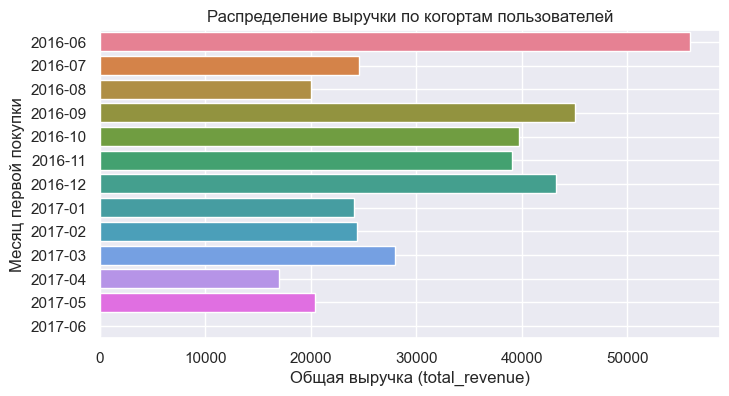

In [97]:
# Построим график распределения выручки
plt.figure(figsize=(8, 4))
sns.barplot(x='total_revenue', y='first_buy_date', data=df_cohort, palette='husl')
plt.xlabel('Общая выручка (total_revenue)')
plt.ylabel('Месяц первой покупки')
plt.title('Распределение выручки по когортам пользователей')
plt.grid(True)
plt.show()

In [98]:
# Создадим новый признак средний чек и отсортируем датафрейм по убыванию этого значения
df_cohort['avg_bill'] = round(df_cohort['total_revenue'] / df_cohort['pays_num'], 2)

In [99]:
df_cohort.sort_values(by='avg_bill', ascending=False, inplace=True)
df_cohort

,first_buy_date,pays_num,clients_num,total_revenue,avg_bill
12,2017-06,4,4,41.30,10.32
3,2016-09,5848,4068,45017.64,7.70
0,2016-06,9171,3508,55974.60,6.10
2,2016-08,3528,2233,19978.82,5.66
1,2016-07,4465,3077,24558.22,5.50
6,2016-12,8463,6573,43194.81,5.10
5,2016-11,8416,6076,39046.25,4.64
4,2016-10,9023,6731,39760.12,4.41
10,2017-04,3880,3368,16991.42,4.38
9,2017-03,6498,5214,27962.06,4.30


Построим график распределения среднего чека и предварительно удалим значения июня 2017 года т.к. выборки недостаточно, чтобы делать выводы о значение среднего чека.

In [100]:
# Удаляем строку с '2017-06'
index_to_drop = df_cohort[df_cohort['first_buy_date'] == '2017-06'].index
df_cohort.drop(index_to_drop, inplace=True)

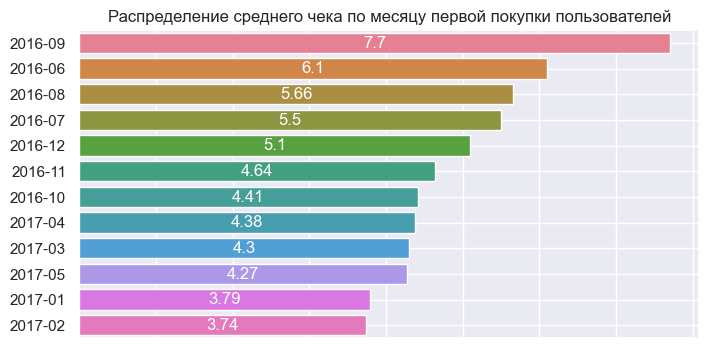

In [101]:
# Настройка размера фигуры
plt.figure(figsize=(8, 4))

# Создание бар-диаграммы
ax = sns.barplot(x='avg_bill', y='first_buy_date', data=df_cohort, palette='husl')

# Установка подписей
for i, p in enumerate(ax.patches):
    # Вычисляем позицию текста
    x_pos = p.get_x() + p.get_width() / 2
    y_pos = p.get_y() + p.get_height() / 2
    
    # Форматируем значение
    value = f"{round(p.get_width(), 2)}"
    
    # Добавляем подпись
    ax.text(x_pos, y_pos, f"{value}", ha='center', va='center', color='white')

# Подписи осей и заголовка
plt.xlabel('')
plt.ylabel('')
plt.title('Распределение среднего чека по месяцу первой покупки пользователей')
plt.grid(True)
ax.set_xticklabels([])

plt.show()

**Ответ**: Наибольший средний чек у пользователей которые соврешили первую покупку в сентябре 2016 года, наименьший у пользоватлей совершивших первую покупку в феврале 2017 года.

### Наибольший доход помесячно 

**Вопрос**: С какого source_id мы получили больший доход помесячно, учитывая , что покупку относим к id источника последнего перед покупкой визита?

In [102]:
# Создаём новый столбец с месяцем и годом
merged_df['month_year'] = merged_df['buy_dt'].dt.strftime('%Y-%m')

# Создаем сводную таблицу, в которой в качестве индекса будет месяц продажи, а в столбцах источник траффика
source_df = pd.pivot_table(merged_df, values='revenue', index='month_year', 
                           columns='source_id', aggfunc='sum').reset_index().rename_axis(None, axis=1)

In [103]:
source_df

,month_year,1,2,3,4,5,7,9,10
0,2016-06,2724.90,2595.71,3512.53,2978.78,3465.54,NaN,383.00,340.13
1,2016-07,3846.88,3064.76,4150.04,4212.67,4009.90,NaN,317.61,266.22
2,2016-08,2418.24,1879.24,2389.43,2878.94,3787.48,3.16,359.87,276.95
3,2016-09,6117.13,4577.56,5000.53,4773.14,8559.89,NaN,447.46,284.61
4,2016-10,8202.00,8601.42,6529.74,8595.25,9931.30,0.18,691.38,961.10
5,2016-11,9210.71,9491.05,7560.41,9516.56,7086.55,NaN,806.97,727.23
6,2016-12,7772.34,13549.65,9831.34,9234.38,7917.99,NaN,606.23,375.86
7,2017-01,5931.09,5483.82,5540.14,6719.20,5670.00,NaN,461.33,450.21
8,2017-02,5919.75,8715.06,6060.83,7486.22,7910.21,NaN,574.18,584.72
9,2017-03,8191.69,9187.05,6127.79,7656.19,7246.21,NaN,865.16,853.32


Для наглядной визуализации удалим июнь 2017 года, также 7, 9, 10 источник трафика, т.к. они генерируют относительно небольшую выручку

In [104]:
filtered_source = source_df.iloc[:-1, :6]

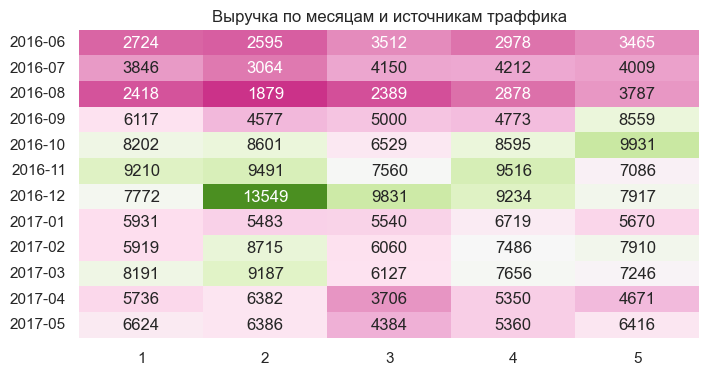

In [105]:
# Оставляем только числовые столбцы и столбец 'buy_dt'
numeric_columns = [1, 2, 3, 4, 5]
data_for_heatmap = filtered_source[['month_year'] + numeric_columns]

# Устанавливаем индекс по дате
data_for_heatmap.set_index('month_year', inplace=True)

# Форматирование аннотаций
def format_number(x):
    return f"{int(x):d}"

# Создание heatmap
plt.figure(figsize=(8, 4))
ax = sns.heatmap(data_for_heatmap, annot=True, fmt='', cmap='PiYG', 
                 annot_kws={'fontsize': 12}, cbar=False, vmin=0, vmax=15000)

# Применение пользовательского форматирования
for text in ax.texts:
    text.set_text(format_number(float(text.get_text())))

plt.title('Выручка по месяцам и источникам траффика')
plt.xlabel('')
plt.ylabel('')
plt.show()

По этой тепловой карте видно, что лучший месяц по выручке обеспечил второй источник в декабре 2016 года, худший месяц по выручке также у второго источника в августе 2016 года.

In [106]:
# Сгруппируем данные по месяцу и источнику.
grouped = merged_df.groupby(['month_year', 'source_id'], as_index=False)['revenue'].sum()

# Группируем данные по month_year и находим max revenue
max_revenue_by_month = grouped.groupby('month_year')['revenue'].max().reset_index()

# Объединяем исходный датафрейм с результатом группировки
result = grouped.merge(max_revenue_by_month, on=['month_year', 'revenue'], how='inner')

In [107]:
result

,month_year,source_id,revenue
0,2016-06,3,3512.53
1,2016-07,4,4212.67
2,2016-08,5,3787.48
3,2016-09,5,8559.89
4,2016-10,5,9931.30
5,2016-11,4,9516.56
6,2016-12,2,13549.65
7,2017-01,4,6719.20
8,2017-02,2,8715.06
9,2017-03,2,9187.05


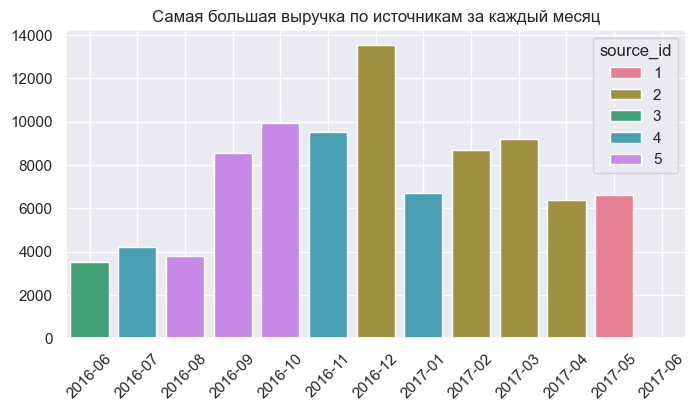

In [108]:
# Настройка размера фигуры
plt.figure(figsize=(8, 4))

# Создание бар-диаграммы
custom_palette = sns.color_palette("husl", len(result["source_id"].unique()))
ax = sns.barplot(y='revenue', x='month_year', data=result, palette=custom_palette, hue='source_id')

# Подписи осей и заголовка
plt.xlabel('')
plt.ylabel('')
plt.title('Самая большая выручка по источникам за каждый месяц')
plt.grid(True)
plt.xticks(rotation=45)

plt.show()

В данном случае видно, что чаще всего наибольшую выручку за месяц получали второй, пятый и четвертый источники.

**Ответ**: Наибольший доход в сравнении по источникам трафика за месяц следующий
| month_year | source_id |   revenue |
|------------|-----------|-----------|
| 2016-06    |         3 |   3512.53 |
| 2016-07    |         4 |   4212.67 |
| 2016-08    |         5 |   3787.48 |
| 2016-09    |         5 |   8559.89 |
| 2016-10    |         5 |   9931.30 |
| 2016-11    |         4 |   9516.56 |
| 2016-12    |         2 |  13549.65 |
| 2017-01    |         4 |   6719.20 |
| 2017-02    |         2 |   8715.06 |
| 2017-03    |         2 |   9187.05 |
| 2017-04    |         2 |   6382.92 |
| 2017-05    |         1 |   6624.96 |
| 2017-06    |         4 |     32.50 |

### LTV по когортам пользователей

**Вопрос**: Какой LTV на каждую когорту пользователей (по месяцу первой покупки)?

In [109]:
# Выберем только необходимые для формирования когорт данные
cohort_month = merged_df[merged_df['revenue'] > 0][['uid', 'buy_dt', 'revenue', 'month_year']]

# Группировка по uid и выбор минимальной даты покупки на уровне месяца
first_buy_dates = cohort_month.groupby('uid')['buy_dt'].min().dt.strftime('%Y-%m')

# Присоединяем результат обратно к исходному DataFrame
cohort = cohort_month.merge(pd.DataFrame({'uid': first_buy_dates.index, 
                                      'first_month_year': first_buy_dates.values}), 
                                      on='uid', how='left')
cohort['first_month_year'] = cohort['first_month_year'].apply(lambda x: pd.Period(x, freq='M'))

In [110]:
# Создадим функцию для создания столбцов с годом днем и месяцем из даты

def get_date(df,column):
    year=df[column].dt.year
    month=df[column].dt.month
    day=df[column].dt.day
    return year,month,day

date_year, date_month, _ = get_date(cohort,'buy_dt')
cohort_year, cohort_month , _ = get_date(cohort,'first_month_year')
year_diff = date_year - cohort_year
month_diff = date_month - cohort_month

# Рассчитаем месяц совершения операции для каждой когорты
cohort['cohort_index'] = year_diff * 12 + month_diff + 1

In [111]:
# Создадим сводную таблицу с количеством уникальных клиентов
data_clients = cohort.pivot_table(index = 'first_month_year',
                      columns = 'cohort_index',
                      values = 'uid',
                      aggfunc = 'nunique')

In [112]:
# Теперь создадим таблицу с суммой выручки по когортам
data = cohort.pivot_table(index = 'first_month_year',
                           columns = 'cohort_index',
                           values = 'revenue',
                           aggfunc = 'sum')

# И разделим таблицу с выручкой на кол-во уникальных клиентов в первый месяц 
first_column = data_clients.iloc[:,0]
cohort_arpu = data.div(first_column, axis=0)

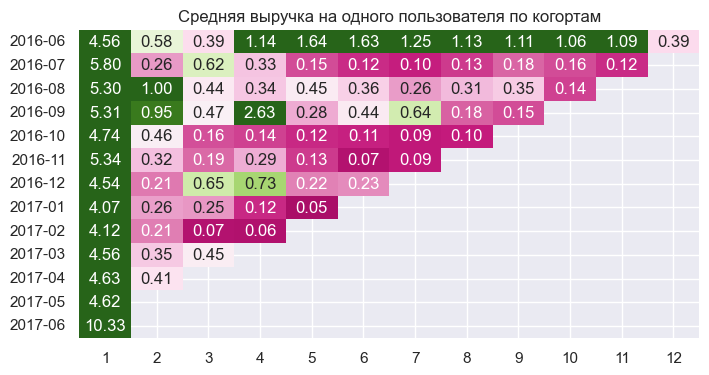

In [113]:
# Также построим тепловую карту по этой таблице
plt.figure(figsize=(8,4))
plt.title('когортный анализ-retention')
sns.heatmap(data = cohort_arpu,
           annot = True,
           fmt='.2f',
           vmin = 0,
           vmax = 1,
           cmap = "PiYG",
           cbar=False)
plt.title('Средняя выручка на одного пользователя по когортам')
plt.xlabel('')
plt.ylabel('')
plt.show()

Мы рассчитали среднюю выручку на одного пользователя по когортам, теперь рассчитаем накопительную среднюю выручку по когортам

In [114]:
cumulative_sums = cohort_arpu.cumsum(axis=1)

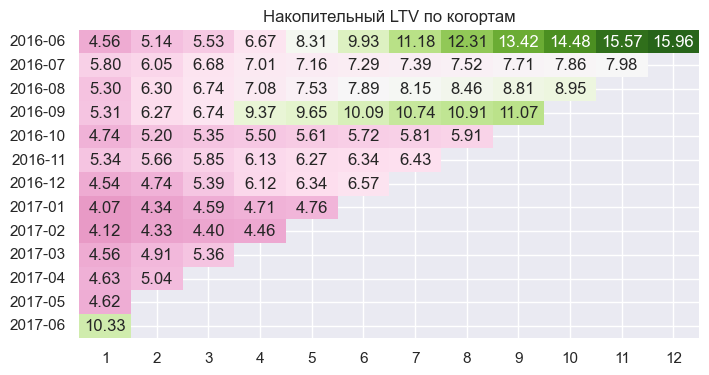

In [115]:
# Визуализируем полученный результат
plt.figure(figsize=(8,4))
plt.title('когортный анализ-retention')
sns.heatmap(data = cumulative_sums,
           annot = True,
           fmt='.2f',
           vmin = 0,
           vmax = 16,
           cmap = "PiYG",
           cbar=False)
plt.title('Накопительный LTV по когортам')
plt.xlabel('')
plt.ylabel('')
plt.show()

**Ответ**: Теперь мы можем сравнивать накопительный LTV по когортам. По данному графику можно сказать, что когорты июня, августа и сентября 2016 года показывают лучшую динамику. С помощью данной таблицы мы можем оценивать эффекивность маркетинговых коммуникаций за каждый месяц.

### Аномалии в трафике

**Вопрос**: Какие аномалии в трафике видите, если они есть?

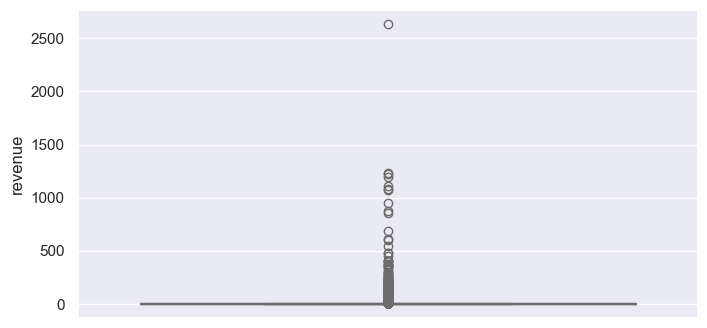

In [116]:
# Визуализируем распределение данных по сумме чека
plt.figure(figsize=(8, 4))
sns.boxplot(merged_df['revenue'], palette='husl')
plt.show()

In [117]:
# Сравним с медианным значением
print('Медианная сумма чека', merged_df['revenue'].median())

Медианная сумма чека 2.57


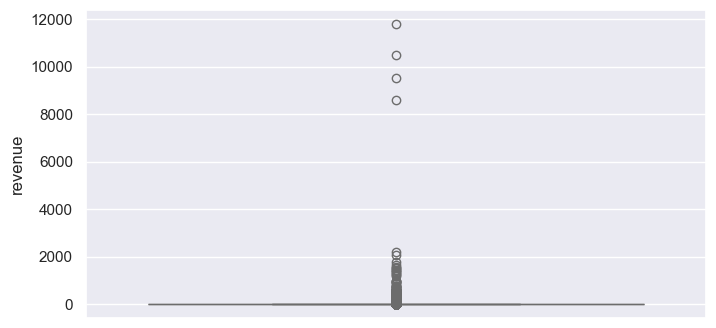

In [118]:
# И по общей выручке на пользователя
plt.figure(figsize=(8, 4))
sns.boxplot(clients_gr['revenue'], palette='husl')
plt.show()

In [119]:
# Также найдем медианное значение общей выручки
print('Медианная общая выручка на платящего пользователя пользователя', 
      clients_gr[clients_gr['revenue'] > 0]['revenue'].median())

Медианная общая выручка на платящего пользователя пользователя 2.93


**Ответ**: Есть небольшая доля клиентов с аномальным значениями как чеков так и общей выручки, это может свидетельствовать об ошибке в данных, но для того чтобы сделать такие выводы информации не достаточно.

### Ежемесячные затраты на трафик по устройствам и источникам.

**Вопрос**: Учитывая , что за визит нового уникального пользователя (первый визит) мы платим 0,01 у.е. sourceid , приведшему его , необходимо рассчитать помесячно затраты на трафик на каждый девайс и sourceid.

In [120]:
# Выберем необходимые для анализа данные
traffic = merged_df[['uid', 'start_ts', 'device', 'source_id', 'revenue']].sort_values(by='start_ts')

In [121]:
# Сгруппируем данные по id пользователя
traffic_grouped = traffic.groupby('uid', as_index=False).agg({'start_ts': 'min',
                                                              'device': 'first',
                                                              'source_id': 'first',
                                                              'revenue': 'sum'})
# Создадим два новых столбца с месяцем первого визита и со стоимостью привлечения нового пользователя
traffic_grouped['start_month'] = traffic_grouped['start_ts'].dt.strftime('%Y-%m')
traffic_grouped['acquisition_cost'] = 0.01

In [122]:
# Создаем две сводные таблицы сгруппированные по месяцу первого визита и устройствам (источникам)

traffic_device = traffic_grouped.pivot_table(index = 'start_month',
                           columns = 'device',
                           values = 'acquisition_cost',
                           aggfunc = 'sum')

traffic_source = traffic_grouped.pivot_table(index = 'start_month',
                           columns = 'source_id',
                           values = 'acquisition_cost',
                           aggfunc = 'sum')

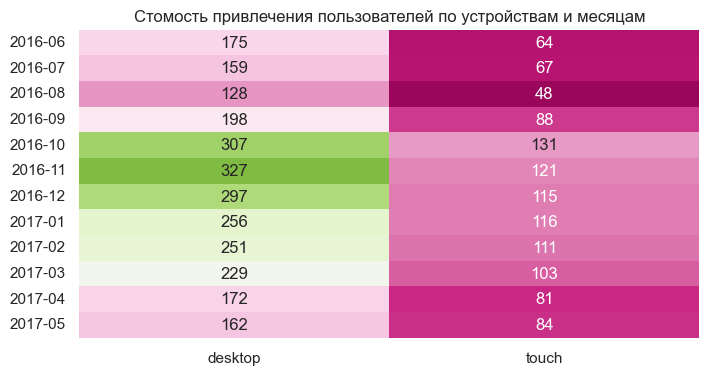

In [123]:
# Создадим тепловые карты по полученным данным для более наглядной визуализации
plt.figure(figsize=(8,4))
plt.title('когортный анализ-retention')

def format_number(x):
    return f"{int(x):d}"

ax = sns.heatmap(data = traffic_device,
           annot = True,
           fmt='',
           vmin = 40,
           vmax = 400,
           cmap = "PiYG",
           cbar=False)

for text in ax.texts:
    text.set_text(format_number(float(text.get_text())))

plt.title('Cтомость привлечения пользователей по устройствам и месяцам')
plt.xlabel('')
plt.ylabel('')
plt.show()

Больше всего клиентов пришло из десктопных устройств в октябре, ноябре и декабре 2016 года. 

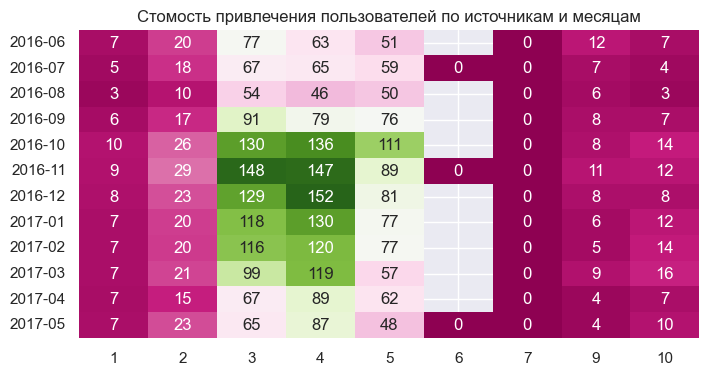

In [124]:
plt.figure(figsize=(8,4))
plt.title('когортный анализ-retention')

def format_number(x):
    return f"{int(x):d}"

ax = sns.heatmap(data = traffic_source,
           annot = True,
           fmt='',
           vmin = 0,
           vmax = 150,
           cmap = "PiYG",
           cbar=False)

for text in ax.texts:
    text.set_text(format_number(float(text.get_text())))

plt.title('Cтомость привлечения пользователей по источникам и месяцам')
plt.xlabel('')
plt.ylabel('')
plt.show()

3, 4 и 5 каналы привлечения выделяются по количество затрат.

**Ответ**:

Затраты на привлечение пользователей по устройствам
| start_month | desktop | touch  |
|-------------|---------|--------|
| 2016-06     | 175.26  | 64.00  |
| 2016-07     | 159.96  | 67.83  |
| 2016-08     | 128.70  | 48.18  |
| 2016-09     | 198.90  | 88.45  |
| 2016-10     | 307.08  | 131.98 |
| 2016-11     | 327.01  | 121.49 |
| 2016-12     | 297.69  | 115.44 |
| 2017-01     | 256.73  | 116.88 |
| 2017-02     | 251.34  | 111.05 |
| 2017-03     | 229.07  | 103.27 |
| 2017-04     | 172.45  | 81.70  |
| 2017-05     | 162.03  | 84.70  |

Затраты по источнику траффика
| source_id | 1      | 2       | 3        | 4        | 5        | 6     | 7      | 9      | 10     |
|-----------|--------|---------|----------|----------|----------|-------|--------|--------|--------|
| 2016-06   | 7.26   | 20.97   | 77.25    | 63.14    | 51.00    | NaN   | 0.04   | 12.43  | 7.17   |
| 2016-07   | 5.50   | 18.25   | 67.78    | 65.05    | 59.07    | 0.01  | 0.05   | 7.26   | 4.82   |
| 2016-08   | 3.78   | 10.88   | 54.90    | 46.39    | 50.70    | NaN   | 0.03   | 6.40   | 3.80   |
| 2016-09   | 6.59   | 17.10   | 91.90    | 79.60    | 76.35    | NaN   | 0.07   | 8.06   | 7.68   |
| 2016-10   | 10.09  | 26.66   | 130.19   | 136.41   | 111.98   | NaN   | 0.15   | 8.87   | 14.71  |
| 2016-11   | 9.96   | 29.27   | 148.68   | 147.33   | 89.95    | 0.01  | 0.06   | 11.14  | 12.10  |
| 2016-12   | 8.96   | 23.92   | 129.23   | 152.60   | 81.64    | NaN   | 0.11   | 8.27   | 8.40   |
| 2017-01   | 7.70   | 20.53   | 118.61   | 130.66   | 77.49    | NaN   | 0.06   | 6.17   | 12.39  |
| 2017-02   | 7.79   | 20.02   | 116.96   | 120.41   | 77.02    | NaN   | 0.05   | 5.89   | 14.25  |
| 2017-03   | 7.91   | 21.97   | 99.36    | 119.90   | 57.24    | NaN   | 0.04   | 9.82   | 16.10  |
| 2017-04   | 7.28   | 15.32   | 67.27    | 89.97    | 62.44    | NaN   | 0.03   | 4.02   | 7.82   |
| 2017-05   | 7.80   | 23.12   | 65.08    | 87.52    | 48.98    | 0.01  | 0.01   | 4.06   | 10.17  |


